# Local hyperalignment template

In this Notebook, we will go through how to create a hyperalignment template for a region of interest (ROI).

## Preparations

In [1]:
%%capture
%pip install -U neuroboros

In [2]:
import numpy as np
import neuroboros as nb
from scipy.stats import zscore
from scipy.spatial.distance import pdist, cdist, squareform
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from hyperalignment.procrustes import procrustes
from hyperalignment.ridge import ridge

The Life dataset contains fMRI data (a) during watching the Life documentary and (b) during watching videos of various actions of various animals. See Nastase et al. ([2017](https://doi.org/10.1093/cercor/bhx138), [2018](https://doi.org/10.3389/fnins.2018.00316)) for more details.

This example focuses on the movie data (Life documentary).

In [3]:
dset = nb.Life()
sids = dset.subjects

## Region of interest (ROI)

We will use a searchlight from the ventral temporal cortex as the ROI.

In the figure below, the yellow regions are the searchlight for the left and right hemispheres, respectively.
The cyan regions are the "Ventral Stream Visual Cortex" regions from the HCP MMP parcellation (Glasser et al., 2016).

The searchlight index is 4586 for the left hemisphere, and 5876 for the right hemisphere.

:::{image} vt_roi.png
:alt: VT ROI
:width: 500px
:align: center
:::


<div>
<img src="vt_roi.png" alt="VT ROI" style="width:500px;"/>
</div>

## Data matrices for the ROI

In [4]:
sls = nb.sls('r', 20)
roi = sls[5876]
dms = []
for sid in sids:
    dm = dset.get_data(sid, 'life', [1, 2], 'r')
    dm = dm[:, roi]
    dms.append(dm)
dms = np.stack(dms, axis=0)

In [5]:
ns, nt, nv = dms.shape
print(dms.shape)

(19, 704, 122)


## ROI RDMs

In [6]:
rdms = []
for dm in dms:
    rdm = pdist(dm, 'euclidean')
    rdms.append(rdm)
rdms = np.array(rdms)

The average RDM reflects the shared similarity structure across individuals.
The RDM of each individual also reflects the individual's idiosyncrasies.

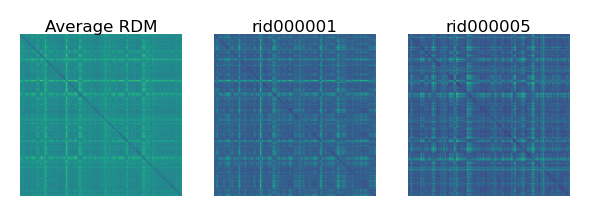

In [7]:
fig, axs = plt.subplots(1, 3, figsize=[_/2.54 for _ in [9, 3]], dpi=200)
mats = [squareform(_) for _ in [rdms.mean(axis=0), rdms[0], rdms[1]]]
for i, (mat, ax) in enumerate(zip(mats, axs)):
    ax.set_title(['Average RDM', sids[0], sids[1]][i], size=6, pad=1)
    ax.imshow(mat, vmin=0)
    ax.axis('off')
plt.show()

## Template with representative representational geometry

### Concatenated data matrix

To create a local template as Feilong et al. (2023), we concatenate all data matrices along the features dimension.
The concatenated matrix is normalized in scale to account for the number of participants.

In [8]:
print(dms.shape)
mega_dm = dms.transpose(1, 0, 2)
print(mega_dm.shape)
mega_dm = mega_dm.reshape(nt, ns * nv)
mega_dm = mega_dm / np.sqrt(ns)
print(mega_dm.shape)

(19, 704, 122)
(704, 19, 122)
(704, 2318)


We can compute an RDM based on the concatenated data matrix, which is fairly similar to the average RDM.

In [9]:
mega_rdm = pdist(mega_dm, 'euclidean')

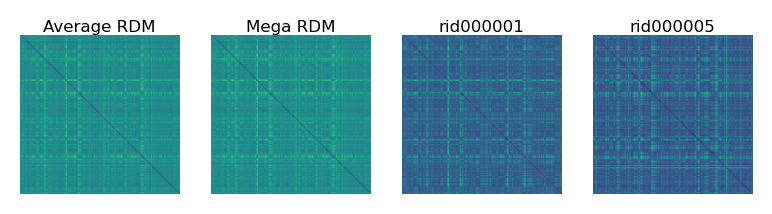

In [10]:
fig, axs = plt.subplots(1, 4, figsize=[_/2.54 for _ in [12, 3]], dpi=200)
mats = [squareform(_) for _ in [rdms.mean(axis=0), mega_rdm, rdms[0], rdms[1]]]
for i, (mat, ax) in enumerate(zip(mats, axs)):
    ax.set_title(['Average RDM', 'Mega RDM', sids[0], sids[1]][i], size=6, pad=1)
    ax.imshow(mat, vmin=0)
    ax.axis('off')
plt.show()

Actually, Euclidean distances are square roots of sum of squared differences.
If we average the squared Euclidean RDMs and square root the average, it will be the same RDM as the one based on concatenated data matrix.

In [11]:
avg_rdm = np.mean(rdms, axis=0)
avg_rdm2 = np.sqrt(np.mean(rdms**2, axis=0))

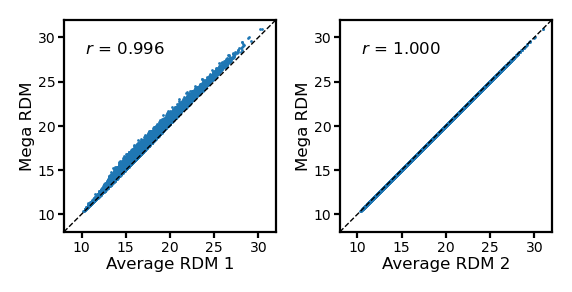

In [12]:
fig, axs = plt.subplots(1, 2, figsize=[_/2.54 for _ in [8, 4]], dpi=200)
for i, (rdm, ax) in enumerate(zip([avg_rdm, avg_rdm2], axs)):
    ax.set_aspect('equal')
    a = rdm
    b = mega_rdm
    ax.scatter(a, b, s=1, lw=0)
    ax.set_xlabel(f'Average RDM {i+1}', size=6, labelpad=1)
    ax.set_ylabel('Mega RDM', size=6, labelpad=1)
    lim = [8, 32]
    ax.plot(lim, lim, 'k--', lw=0.5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
    r, p = pearsonr(a, b)
    ax.annotate(f'$r$ = {r:.3f}', (0.1, 0.9), size=6,
                xycoords='axes fraction', ha='left', va='top')
fig.subplots_adjust(wspace=0.3)
plt.show()

### PCA of the concatenated data matrix

PCA is also a rotation in a high-dimensional space, and it doesn't change the representational geometry.

In [13]:
U, s, Vt = nb.linalg.safe_svd(mega_dm)
pcs = U * s[np.newaxis]
pc_rdm = pdist(pcs, 'euclidean')

In [14]:
pearsonr(pc_rdm, mega_rdm)

PearsonRResult(statistic=0.9999999999999988, pvalue=0.0)

In [15]:
np.testing.assert_allclose(pc_rdm, mega_rdm)

In [16]:
np.testing.assert_allclose(avg_rdm2, mega_rdm)

### Dimensionality reduction based on PCs

If we keep the same number of PCs as the number of vertices in the ROI, the PCs can still explain a lot of variance in the data.

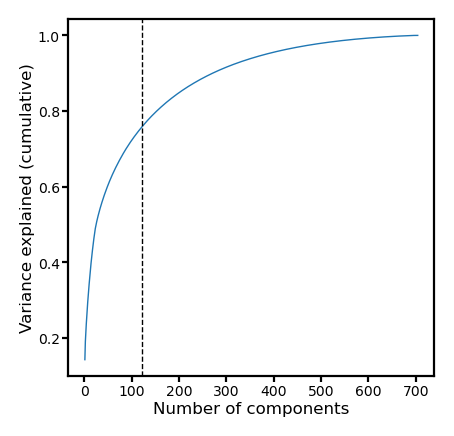

In [17]:
v = s**2
fig, ax = plt.subplots(1, 1, figsize=[_/2.54 for _ in [6, 6]], dpi=200)
ax.plot(np.arange(len(v)) + 1, np.cumsum(v) / np.sum(v), lw=0.5)
ax.set_xlabel(f'Number of components', size=6, labelpad=1)
ax.set_ylabel('Variance explained (cumulative)', size=6, labelpad=1)
ax.axvline(nv, linestyle='--', color='k', lw=0.5)
ax.tick_params('both', size=2, pad=1, labelsize=5)
plt.show()

If we compute explained variance only for the center vertices, it's slightly higher.
The function of the vertices close to the boundary of the searchlight may not be well covered by the template for the searchlight.

In [18]:
r2s = []
centers = dms[:, :, 0].T
ss0 = np.sum(centers**2)
for npc in np.arange(pcs.shape[1]) + 1:
    X = pcs[:, :npc]
    beta = np.linalg.lstsq(X, centers, rcond=None)[0]
    ss = np.sum((centers - X @ beta)**2)
    r2 = 1 - ss / ss0
    r2s.append(r2)
r2s = np.array(r2s)

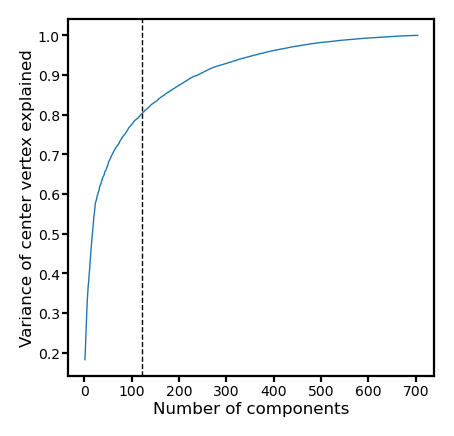

In [19]:
fig, ax = plt.subplots(1, 1, figsize=[_/2.54 for _ in [6, 6]], dpi=200)
ax.plot(np.arange(len(r2s)) + 1, r2s, lw=0.5)
ax.set_xlabel(f'Number of components', size=6, labelpad=1)
ax.set_ylabel('Variance of center vertex explained', size=6, labelpad=1)
ax.axvline(nv, linestyle='--', color='k', lw=0.5)
ax.tick_params('both', size=2, pad=1, labelsize=5)
plt.show()

### RDM after dimensionality reduction

The RDM with only `nv` PCs is still very similar to the one based on all PCs.
In contrast, the RDM based on the average data matrix is very different.

In [20]:
pc_rdm2 = pdist(pcs[:, :nv], 'euclidean')
avg_dm_rdm = pdist(dms.mean(axis=0), 'euclidean')

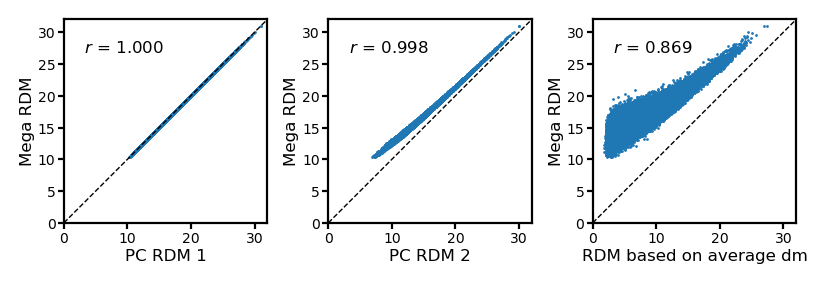

In [21]:
fig, axs = plt.subplots(1, 3, figsize=[_/2.54 for _ in [12, 4]], dpi=200)
for i, (rdm, ax) in enumerate(zip([pc_rdm, pc_rdm2, avg_dm_rdm], axs)):
    ax.set_aspect('equal')
    a = rdm
    b = mega_rdm
    ax.scatter(a, b, s=1, lw=0)
    ax.set_xlabel(f'PC RDM {i+1}' if i < 2 else 'RDM based on average dm',
                  size=6, labelpad=1)
    ax.set_ylabel('Mega RDM', size=6, labelpad=1)
    lim = [0, 32]
    ax.plot(lim, lim, 'k--', lw=0.5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
    r, p = pearsonr(a, b)
    ax.annotate(f'$r$ = {r:.3f}', (0.1, 0.9), size=6,
                xycoords='axes fraction', ha='left', va='top')
fig.subplots_adjust(wspace=0.3)
plt.show()

- By definition, the average RDM has the smallest sum of squared errors.
- The RDM based on concatenated data matrix performs similarly well.
- After dimensionality reduction, the SS slightly increased.
- The RDM based on the average data matrix has much larger SS---Averaging across participants based on anatomically aligned data remove a lot of information in response patterns.

In [22]:
for model in [avg_rdm, mega_rdm, pc_rdm2, avg_dm_rdm]:
    print(((model - rdms)**2).sum())

62619394.34935014
63651823.58465626
76324125.1475749
440438143.7663896


The RDM based on concatenated data matrix performs slightly better if we use squared Euclidean distances.

In [23]:
for model in [avg_rdm, mega_rdm, pc_rdm2, avg_dm_rdm]:
    print(((model**2 - rdms**2)**2).sum())

82673988479.83093
81549177246.46718
97926034314.76741
267146412490.5963


We have successfully created the local PC template as in the paper.

In [24]:
pc_tpl = pcs[:, :nv]
print(pc_tpl.shape)

(704, 122)


## Representative functional topographies

Though the PC template has the same number of features as the data matrices, the features hardly have any correspondence between the PCs and the data matrices.

For example, the PC template and the 1st participant's data matrix are very different.

In [25]:
dm = dms[0]
print((dm**2).sum())
print(((dm - pc_tpl)**2).sum())

85888.0
147023.92535953716


With a rotation based on the orthogonal Procrustes algorithm, the differences can be greatly reduced.

In [26]:
R = procrustes(pc_tpl, dm)
print(R.shape)
print(((dm - pc_tpl @ R)**2).sum())

(122, 122)
72965.18547625224


To reduce the overall dissimilarity between the template and all data matrices, we concatenate the matrices **along the samples dimension** (time series) this time.
We duplicate the PC template and concatenate the duplicates similarly.

In [27]:
YY = dms.reshape(ns * nt, nv)
print(YY.shape)
XX = np.concatenate([pc_tpl] * ns, axis=0)
print(XX.shape)

(13376, 122)
(13376, 122)


Similar to align the template to one participant, we can use Procrustes to rotate the template to match all participants' data matrices.

In [28]:
RR = procrustes(XX, YY)
tpl = pc_tpl @ RR

In [29]:
ss = 0
for dm in dms:
    ss += (dm**2).sum()
print(ss)

1631872.0


The functional topography of the PC template is very different from the data matrices.

In [30]:
ss = 0
for dm in dms:
    ss += ((dm - pc_tpl)**2).sum()
print(ss)

2823391.508136437


After the rotation, they become much more similar.

In [31]:
ss = 0
for dm in dms:
    ss += ((dm - tpl)**2).sum()
print(ss)

2079925.5030061058


By definition, the average data matrix has the smallest sum of squared error.
However, the representational geometry of the average matrix is not representative.

In [32]:
ss = 0
mean_dm = dms.mean(axis=0)
for dm in dms:
    ss += ((dm - mean_dm)**2).sum()
print(ss)

1313215.6618796256


## Using the `compute_template` function

In [33]:
from hyperalignment.local_template import compute_template

In [34]:
tpl2 = compute_template(dms, kind='pca', max_npc=nv, common_topography=False)

By default `compute_template` uses randomized PCA/SVD to increase computational speed, and the components (especially the latter ones) might differ from standard SVD.

In [39]:
np.set_printoptions(4, linewidth=80)

In [40]:
np.mean(zscore(pc_tpl, axis=0) * zscore(tpl2, axis=0), axis=0)

array([-1.    ,  1.    , -1.    ,  1.    ,  1.    , -1.    ,  1.    , -1.    ,
        1.    ,  1.    , -1.    ,  1.    ,  1.    ,  1.    , -1.    , -1.    ,
        1.    , -1.    , -1.    , -1.    ,  1.    ,  1.    , -1.    ,  1.    ,
       -1.    ,  1.    ,  1.    ,  1.    ,  1.    , -1.    , -1.    , -1.    ,
       -1.    , -1.    , -1.    , -1.    , -1.    , -1.    , -1.    ,  1.    ,
       -1.    , -1.    , -0.9999,  0.9999, -0.9999,  0.9998,  0.9999,  0.9999,
       -0.9999, -0.9996, -0.9999,  0.9989, -0.9992, -0.9996,  0.9996, -0.9995,
        0.9992,  0.9994,  0.999 ,  0.9992, -0.9963,  0.9938,  0.996 ,  0.9977,
        0.9972, -0.9977,  0.9941, -0.9912,  0.8565, -0.8549,  0.9868,  0.9863,
        0.9896,  0.9911,  0.9865, -0.9634,  0.9727, -0.9699,  0.9605, -0.954 ,
        0.9612,  0.6856, -0.6997, -0.9832, -0.9621, -0.9624, -0.948 ,  0.9832,
       -0.955 , -0.952 , -0.8977,  0.4023, -0.5036, -0.5138, -0.6063, -0.5309,
        0.5479, -0.6569, -0.6972,  0.7599, -0.8   , 

Turn on `common_topography=True` to also get the representative functional topographies based on the group of training participants.

In [37]:
tpl3 = compute_template(dms, kind='pca', max_npc=nv, common_topography=True)

In [41]:
np.mean(zscore(tpl, axis=0) * zscore(tpl3, axis=0), axis=0)

array([0.9437, 0.9892, 0.9556, 0.9793, 0.9715, 0.9846, 0.9878, 0.9799, 0.9741,
       0.9805, 0.973 , 0.9838, 0.9599, 0.9697, 0.9744, 0.9703, 0.9615, 0.9736,
       0.9659, 0.9454, 0.9827, 0.9699, 0.9361, 0.9797, 0.9722, 0.9891, 0.9591,
       0.9641, 0.9654, 0.975 , 0.9763, 0.9806, 0.9562, 0.9732, 0.9641, 0.9831,
       0.9738, 0.9825, 0.9644, 0.9704, 0.9507, 0.98  , 0.9725, 0.9635, 0.9664,
       0.9821, 0.9819, 0.9549, 0.9863, 0.9797, 0.9617, 0.9761, 0.9797, 0.9757,
       0.9733, 0.9739, 0.9716, 0.9728, 0.9742, 0.952 , 0.9721, 0.9751, 0.9832,
       0.9669, 0.9816, 0.9835, 0.9824, 0.9701, 0.9739, 0.9658, 0.9784, 0.9228,
       0.961 , 0.9869, 0.9668, 0.9797, 0.9609, 0.9814, 0.9768, 0.9557, 0.9635,
       0.9591, 0.9701, 0.955 , 0.9444, 0.9678, 0.9716, 0.9674, 0.9235, 0.9543,
       0.9668, 0.9848, 0.9808, 0.9613, 0.9648, 0.9882, 0.9806, 0.985 , 0.9789,
       0.9701, 0.965 , 0.9748, 0.9782, 0.9838, 0.9674, 0.9742, 0.9632, 0.9848,
       0.9759, 0.9866, 0.9885, 0.944 , 0.9526, 0.981